In [90]:
import os
import numpy as np
import pandas as pd
import csv
from datetime import datetime
from sklearn.metrics import r2_score
import seaborn as sns
import statsmodels.api as sm

from scipy.stats import ttest_1samp, ttest_ind, t
from scipy.stats import shapiro, normaltest, kstest
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.sandwich_covariance import cov_hac

from definitions import target_var, country_col, date_col, save_output, fake_num, show_plots, save_figs, fig_size, sign_level
from util_general import get_table_path, get_impl_date, get_trans, get_donor_countries
from plot_functions import plot_predictions, plot_diff, plot_cumsum, plot_cumsum_impl, plot_qq
from statistical_tests import shapiro_wilk_test, t_test_result

# custom functions
from definitions import all_paths, country_col, year_col, stat, incl_countries, incl_years, model_val
from util_general import read_data, validate_input, get_trans, get_data_path, get_impl_date
from estimators import arco, sc, did

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

from sklearn.linear_model import Lasso
from definitions import fig_size, show_plots, save_figs, treatment_countries
from util_general import get_impl_date, get_fig_path, get_formal_title, get_model_color, get_formal_country_name

from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

In [109]:
timeframe = 'm'
treatment_country = 'ireland'
model = 'lasso'

In [110]:
file_name = f'{model}_{treatment_country}_{timeframe}_act_pred_log_diff'
act_pred_log_diff = read_data(get_table_path(timeframe, 'results', treatment_country, model), file_name).set_index(date_col)
act_pred_log_diff

,act,pred,error
date,,,
2001-01-01,0.083624,-0.004606,0.088230
2001-02-01,0.066749,-0.004606,0.071356
2001-03-01,0.112298,-0.004606,0.116904
2001-04-01,0.012458,-0.004606,0.017064
2001-05-01,0.025783,-0.004606,0.030389
...,...,...,...
2019-06-01,-0.028505,-0.004606,-0.023899
2019-07-01,-0.024543,-0.004606,-0.019936
2019-08-01,-0.020030,-0.004606,-0.015424


In [111]:
file_name = f'{model}_{treatment_country}_{timeframe}_act_pred_log'
act_pred_log = read_data(get_table_path(timeframe, 'results', treatment_country, model), file_name).set_index(date_col)
act_pred_log

,act,pred,error
date,,,
2001-01-01,22.239254,22.151024,0.088230
2001-02-01,22.175884,22.104529,0.071356
2001-03-01,22.246109,22.129205,0.116904
2001-04-01,22.150462,22.133398,0.017064
2001-05-01,22.033825,22.003436,0.030389
...,...,...,...
2019-06-01,21.772783,21.817947,-0.045164
2019-07-01,21.762147,21.759080,0.003067
2019-08-01,21.752129,21.746119,0.006009


In [112]:
file_name = f'{model}_{treatment_country}_{timeframe}_act_pred'
act_pred = read_data(get_table_path(timeframe, 'results', treatment_country, model), file_name).set_index(date_col)
act_pred

,act,pred,error
date,,,
2001-01-01,4.553918e+09,4.169341e+09,3.845775e+08
2001-02-01,4.274293e+09,3.979924e+09,2.943687e+08
2001-03-01,4.585242e+09,4.079354e+09,5.058878e+08
2001-04-01,4.166998e+09,4.096495e+09,7.050289e+07
2001-05-01,3.708247e+09,3.597252e+09,1.109951e+08
...,...,...,...
2019-06-01,2.856271e+09,2.988229e+09,-1.319582e+08
2019-07-01,2.826054e+09,2.817399e+09,8.654884e+06
2019-08-01,2.797882e+09,2.781120e+09,1.676276e+07


# Significance

In [113]:
df_eval = act_pred_log_diff

df_pre = df_eval[df_eval.index < get_impl_date(treatment_country=treatment_country)]
df_post = df_eval[df_eval.index >= get_impl_date(treatment_country=treatment_country)]

df_eval

,act,pred,error
date,,,
2001-01-01,0.083624,-0.004606,0.088230
2001-02-01,0.066749,-0.004606,0.071356
2001-03-01,0.112298,-0.004606,0.116904
2001-04-01,0.012458,-0.004606,0.017064
2001-05-01,0.025783,-0.004606,0.030389
...,...,...,...
2019-06-01,-0.028505,-0.004606,-0.023899
2019-07-01,-0.024543,-0.004606,-0.019936
2019-08-01,-0.020030,-0.004606,-0.015424


NormaltestResult(statistic=6.790098924422731, pvalue=0.03353889522319685)
ShapiroResult(statistic=0.9759222269058228, pvalue=0.04199520871043205)
KstestResult(statistic=0.4280399107814471, pvalue=5.556166727459108e-19, statistic_location=-0.1584555556700314, statistic_sign=-1)


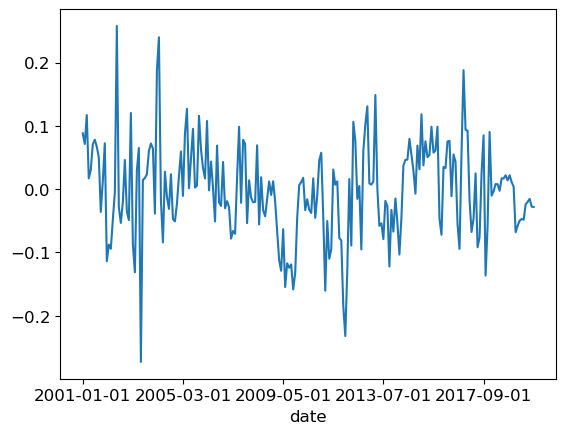

In [114]:
# normal errors
df_eval['error'].plot()

print(normaltest(df_pre['error']))
print(shapiro(df_pre['error']))
print(kstest(df_pre['error'], 'norm'))

In [115]:
# serially correlated errors
print(durbin_watson(df_eval['error']))
print(durbin_watson(df_pre['error']))
print(durbin_watson(df_post['error']))

1.2253067296346591
1.3649377951959902
1.0508094747985863


In [116]:
# t-test
att_mean = df_post['error'].mean()
att_std = df_post['error'].std()
print(f'ATT (mean): {round(att_mean,4)}')
print(f'ATT (std):  {round(att_std,4)}')

ATT (mean): -0.0035
ATT (std):  0.0705


In [108]:
# 1-sample t-test on errors
for alt in ['two-sided', 'less']:
    p_value = ttest_1samp(df_post['error'], popmean=0, alternative=alt).pvalue

    if p_value < sign_level:
        significant = 1
        print(f'{alt} result is significant (p-value={p_value})')
    else:
        significant = 0
        print(f'{alt} result is NOT significant (p-value={p_value})')

two-sided result is NOT significant (p-value=0.3788821595720867)
less result is NOT significant (p-value=0.8105589202139567)


In [88]:
# 2-sample t-test on actuals and predictions
for alt in ['two-sided', 'less']:
    p_value = ttest_ind(a=df_post['act'], b=df_post['pred'], equal_var=False, alternative=alt).pvalue

    if p_value < sign_level:
        significant = 1
        print(f'{alt} result is significant (p-value={p_value})')
    else:
        significant = 0
        print(f'{alt} result is NOT significant (p-value={p_value})')

two-sided result is NOT significant (p-value=0.23656280951843653)
less result is NOT significant (p-value=0.11828140475921826)


In [89]:
# serially correlated
att_mean = df_post['error'].mean()
att_std = df_post['error'].std()

T = len(df_eval)
T_pre = len(df_pre)
T_post = len(df_post)
dof = T_post - 1
gamma_1 = sum(df_pre['error']**2) / T_pre
gamma_2 = sum(df_post['error'] ** 2) / T_post
omega_hat_sqrt = np.sqrt(gamma_1 / (T_pre/T) + gamma_2 / (T_post/T))
t_stat = att_mean / (omega_hat_sqrt / np.sqrt(T))

for alt in ['two-sided', 'less']:
    if alt == 'two-sided':
        p_value = 2*(1 - t.cdf(abs(t_stat), dof))
    else:
        p_value = (1 - t.cdf(abs(t_stat), dof))

    if p_value < sign_level:
        significant = 1
        print(f'{alt} result is significant (p-value={p_value})')
    else:
        significant = 0
        print(f'{alt} result is NOT significant (p-value={p_value})')

two-sided result is significant (p-value=0.06665583242681672)
less result is significant (p-value=0.03332791621340836)
